# Obtaining information about odor from PubChem

TODO:
- For the slights/blands, it's not that I think the label inherently means odorless.
- I would also add "mild" to that list - found that one a few times since I sent the first e-mail.
- Maybe we could pull the slight/bland/mild odors and do some more visual inspection.-
- If the majority are improbable odors we can drop the set. 

In [21]:
%matplotlib inline
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrfume
from pyrfume import pubchem
import re
import requests
from tqdm.auto import tqdm

In [7]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
def update_results(records, results):
    """For a given set of PubChem records, add any strings with the matching keywords to the list of results"""
    keywords = ('odor', 'odour', 'smell', 'aroma ', 'aroma,', 'aroma.', 'fragrance')
    for annotation in records['Annotations']['Annotation']:
        try:
            cids = annotation['LinkedRecords']['CID']
        except:
            pass
        else:
            strings = [] 
            for x in annotation['Data']:
                for y in x['Value']['StringWithMarkup']:
                    if any([z in y['String'].lower() for z in keywords]):
                        strings.append(y['String'])
            for cid in cids:
                if cid in results:
                    results[cid] += strings
                elif strings:
                    results[cid] = strings

In [9]:
def get_results(heading):
    """Get all records under a given record heading from PubChem/
    Update results from those records."""
    page = 1
    results = {}
    with tqdm(total=100) as pbar:
        while True:
            url = (f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/annotations/heading/"
                   f"JSON?heading_type=Compound&heading={heading}&page={page}")
            response = requests.get(url)
            records = response.json()
            update_results(records, results)
            totalPages = records['Annotations']['TotalPages']
            if page==1:
                pbar.reset(total=totalPages)
            pbar.set_description("%d CIDs described" % len(results))
            pbar.update()
            page += 1
            if page > totalPages:
                break
    return results

In [11]:
def make_hist(results):
    """Show a histogram of results by PubChem ID number
    This is useful for showing the density of information as you get to more and more obscure molecules"""
    plt.hist(np.log10(list(results.keys())), bins=np.arange(10));
    xticks = np.arange(10)
    plt.xticks(xticks, ['$10^%d$' % x for x in xticks]);
    plt.xlabel('PubChem ID')
    plt.ylabel('Entry Count')

In [10]:
# Get all results from PubChem under the "Physical Description" heading
pd_results = get_results("Physical+Description")

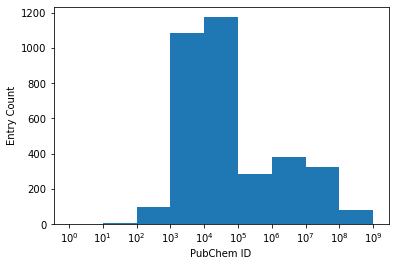

In [12]:
# Show the histogram for odor information under then Physical Description heading
make_hist(pd_results)

In [13]:
# Get all results from PubChem under the "Record Description" heading
rd_results = get_results("Record+Description")

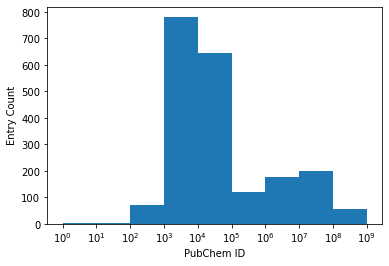

In [14]:
# Show the histogram for odor information under then Physical Description heading
make_hist(rd_results)

In [15]:
# To what extent do these two headings give odor information about the same molecules vs different molecules
# Shown as RD, PD, RD but not PD, PD but not RD
rd_cids = set(key for key in rd_results)
pd_cids = set(key for key in pd_results)
len(rd_cids), len(pd_cids), len(rd_cids.difference(pd_cids)), len(pd_cids.difference(rd_cids))

(2057, 3433, 135, 1511)

In [16]:
# Make a master list of all odor statements from these sources, removing duplicates
all_statements = {}
cids = sorted(set(rd_cids) | set(pd_cids))
for cid in cids:
    rs = rd_results.get(cid, [])
    ps = pd_results.get(cid, [])
    all_statements[cid] = rs + ps
len(all_statements)

3568

In [18]:
def color(cid, s, code):
    """A function for color styling in the HTML output"""
    return "<p style='color: %s'>%d: %s</p>" % (code, cid, s)

# Assignment of particular phrases, matched via regular expressions, to the odorous, odorless, and ambiguous categories.
# Refine as needed.
# 'aroma' needs the trailing space to avoid matching 'aromatic' which has chemical but not necessarily olfactory implications
odorous_phrases = ['odor', 'odour', 'smell', 'fragrance', 'aroma ', 'sense of smell']
odorless_phrases = ['no odor', 'no odour', 'no smell', 'no fragrance', 'odorless', 'odourless']
ambiguous_phrases = ['odoratus']

def make_html(all_statements):
    ### Make an HTML file with the statements and their encoding.
    html = ""
    for cid, statements in all_statements.items():
        for statement in statements:
            statement = statement.lower()
            if any([re.findall(phrase, statement) for phrase in odorless_phrases]):
                html += color(cid, statement, '#DD0000')
            elif any([re.findall(phrase, statement) for phrase in ambiguous_phrases]):
                html += color(cid, statement, '#000000')
            elif any([re.findall(phrase, statement) for phrase in odorous_phrases]):
                html += color(cid, statement, '#009900')
            else:
                html += color(cid, statement, '#000000')
    return html

# Create the HTML file
html = make_html(all_statements)

# Save the HTML file
with open('../../pyrfume-data/pubchem/pubchem_scrape.html', 'w') as f:
    f.write(html)

In [19]:
# Save a Python pickle file of all the statements in the Pyrfume data repository
path = 'pubchem/pubchem_scrape.pkl'
pyrfume.save_data(all_statements, path)

In [26]:
# Create a dataframe to store the statements
df = pd.DataFrame(index=sorted(all_statements),
                  columns=['Odor', 'Odorless', 'Statements'])
df.index.name = 'CID'

# Fill this dataframe with the assignment (odor, odorless, or (!!) both),
# and the corresponding statements supporting that assignment
for cid in sorted(all_statements):
    statements = all_statements[cid]
    odor = False
    odorless = False
    for statement in statements:
        statement = statement.lower()
        if re.findall('no odor', statement):
            odorless = True
        elif re.findall('no odour', statement):
            odorless = True
        elif re.findall('no smell', statement):
            odorless = True
        elif re.findall('no fragrance', statement):
            odorless = True
        elif re.findall('odorless', statement):
            odorless = True
        elif re.findall('odourless', statement):
            odorless = True
        elif re.findall('odoratus', statement):
            pass
        elif re.findall('sense of smell', statement):
            odor = True
        elif re.findall('odor', statement):
            odor = True
        elif re.findall('odour', statement):
            odor = True
        elif re.findall('smell', statement):
            odor = True
        elif re.findall('fragrance', statement):
            odor = True
        elif re.findall('aroma ', statement):
            odor = True
        else:
            pass
    # Uncomment the two lines below to see cases where this happens.
    #if odor and odorless:
    #    print("\nOdorous and odorless! Statements were: " + str(statements))
    df.loc[cid, :] = [odor, odorless, statements]

In [28]:
# Preview this assignments
df.head(20)

,Odor,Odorless,Statements
CID,,,
4,True,False,[Monoisopropanolamine appears as a colorless l...
6,True,False,"[1-chloro-2,4-dinitrobenzene appears as pale y..."
11,True,False,"[1,2-Dichloroethane, also called ethylene dich..."
13,True,False,"[1,2,4-trichlorobenzene appears as colorless l..."
33,True,False,[2-chloroethanal appears as a clear colorless ...
34,True,False,[Ethylene chlorohydrin is a colorless liquid w...
66,True,False,"[Prisms (from benzene, petroleum ether) or whi..."
107,True,False,"[White crystalline solid, faint, sweet, somewh..."
125,True,False,[White crystalline powder; slightly fruity-swe...
